In this notebook, my objective is to create a model for the microvasculature structures dataset. The task at hand is to accurately locate and predict the microvasculature structures present in kidney histology slides. It's an exciting challenge, isn't it? This initial attempt represents a basic model to tackle this task. As I continue my work, I plan to explore more advanced models and solutions to further improve the results. I hope you find these insights helpful and informative!


`Problem`:

Segmentation task (labeling each pixel within the image)

`Method`:

UNET algorithm (Encoder/Decoder mode)

"Dataset:
[kaggle](kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview)


**Point**: Remember, the best score reached in the competition is slightly better than 0.5. So, don't get your hopes up :)


In [1]:
!pip install -q torchview
!pip install -q torchviz
!pip install -q torchmetrics
!pip install -q mlflow

from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
Mounted at /content/drive


# A) Packages

In [1]:
import numpy as np
import pandas as pd
import json
import os
import seaborn
import cv2
import tqdm
import torch
import glob
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# import torchview
import graphviz
from torchview import draw_graph
import matplotlib.pyplot as plt
from torchviz import make_dot
import mlflow
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import sys

import warnings
warnings.filterwarnings("ignore")

sys.path.append("/content/drive/MyDrive/ZamanPersonalUsage/vesselSegmentation/src")

from modelArchitecture import UNet
from utils import normalize
from dataUtils import dataset_class
from callBacks import CallBacks

# B) EDA

Three classes of data are availabel in the current dataset.

**- blood vessel**
The target structure. Your goal in this competition is to predict these kinds of masks on the test set


**- glomerulus** A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should ensure none of your test set predictions occur within glomerulus structures as they will be counted as false positives. Annotations are provided for test set tiles in the hidden version of the dataset.


**- unsure** A structure the expert annotators cannot confidently distinguish as a blood vessel.


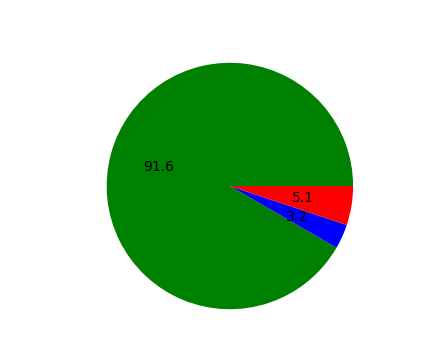

{'blood_vessel': 16054, 'glomerulus': 567, 'unsure': 897}


In [2]:
path = "/content/drive/MyDrive/ZamanPersonalUsage/vesselSegmentation/data/RawData/polygons.jsonl"

# Counting each tissue
counter = {"blood_vessel": 0,
           "glomerulus": 0,
           "unsure": 0}

with open(path, "r") as file:
    for line in file:
        json_data = json.loads(line)
        annotation = json_data["annotations"]
        for annot in annotation:
            tissu_label = annot["type"]
            counter[tissu_label] += 1

plt.figure(figsize=(7, 4), facecolor='none')  # Set facecolor to 'none' for transparent background
pie = plt.pie(list(counter.values()),
        labels=list(counter.keys()),
        colors=["green", "blue", "red"],
        autopct='%1.1f',
        )
plt.title("Tissues distribution", color="white")
plt.setp(pie[1], color='white')
plt.show()

print(counter)


As you can see, blood vessels make up the majority of our data. We should apply some methods that are more appropriate in the case of an imbalanced dataset.

# C) Data preperation
`Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

In [3]:
train_imgs = glob.glob(f"/content/drive/MyDrive/ZamanPersonalUsage/vesselSegmentation/data/train/image/*tif")
# train_masks =  "../../train/mask"

validation_imgs = glob.glob("/content/drive/MyDrive/ZamanPersonalUsage/vesselSegmentation/data/validation/image/*.tif")
# validation_masks =  "../../validation/mask"

In [4]:
print(f"Number of train images: {len(train_imgs)}")
print(f"Number of validation images: {len(validation_imgs)}")

Number of train images: 690
Number of validation images: 270


it is often beneficial to normalize the input images in a dataset, including setting the mean and standard deviation values appropriately. The commonly used values you mentioned, (0.485, 0.456, 0.406) for the mean and (0.229, 0.224, 0.225) for the standard deviation, are the mean and standard deviation values calculated from the ImageNet dataset. These values have been found to work well as general defaults for many computer vision tasks.

However, for your specific dataset, it is recommended to calculate the mean and standard deviation values from your own dataset if possible. This ensures that the normalization is tailored to the statistics of your data. To calculate the mean and standard deviation, you can iterate over your dataset and calculate the per-channel mean and standard deviation values


Normalization is typically applied to input images to bring them to a standard range and ensure consistent training behavior. However, for masks representing categorical labels, preserving the original intensity values is often more important than normalization.

In [20]:
# Mean and STD vector
mean, std = normalize(train_imgs)

Mean: 0.6289172446382219 0.41385530680418015 0.6851008105969083
Std Deviation: 0.145370125738175 0.19595239435093126 0.12320174462823333


In practice, it is common to round the mean values to a reasonable number of decimals, such as 4 or 5, for better readability without sacrificing meaningful precision.

In [21]:
mean = np.round(mean, decimals=4)
std = np.round(std, decimals=4)

# Saving the mean and std for later usage
averageValFile = "/content/drive/MyDrive/ZamanPersonalUsage/vesselSegmentation/configs/meanStdValue.json"
with open(averageValFile, "w") as file:
    json.dump((mean.tolist(), std.tolist()), file)

print("Mean: ", mean)
print("STD: ", std)

Mean:  [0.6289 0.4139 0.6851]
STD:  [0.1454 0.196  0.1232]


In [5]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.6306, 0.4172, 0.6865), (0.1458, 0.1961, 0.1234))
])

In [6]:
batch_size = 8
# Using cuda to process
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {"num_workers": 0,
        "pin_memory" : True} if device == "cuda" else {}

# Preparing the train data generator
trainds = dataset_class(train_imgs, transform=data_transforms)
TrainLoader = torch.utils.data.DataLoader(trainds,
                                        batch_size= batch_size,
                                        shuffle = True,
                                        **kwargs)

# Preparing the validation data generator
validationds = dataset_class(validation_imgs, transform=data_transforms)
ValLoader = torch.utils.data.DataLoader(validationds,
                                        batch_size= batch_size,
                                        shuffle=True,
                                        **kwargs)

## D) Lets look at out data
The BEST thing to do in machine learning problems!

In [ ]:
fig, ax = plt.subplots(batch_size-1, 3, figsize=(20, 35))

for img_batch, mask_batch in TrainLoader:
    for counter in range(len(img_batch)-1):
        img, mask = img_batch[counter], mask_batch[counter]

        # Reordering the dimensions
        img = img.permute(2, 1, 0).numpy()
        # Since we standardized the pictures
        img = img * std + mean

        mask = mask.permute(1, 0).numpy()

        # Overlay mask image to the original image
        overlayed_img = cv2.bitwise_and(img, img, mask=mask)

        ax[counter, 0].imshow(img)
        ax[counter, 0].set_title("Original Image")
        ax[counter, 0].axis("off")

        ax[counter, 1].imshow(mask)
        ax[counter, 1].set_title("Mask")
        ax[counter, 1].axis("off")

        ax[counter, 2].imshow(overlayed_img)
        ax[counter, 2].set_title("Overlayed Image")
        ax[counter, 2].axis("off")

    plt.show()

    break

Output hidden; open in https://colab.research.google.com to view.

### Well!
Looks like a hard problem. Doesn't it? :)

# E) Model

UNET is a deep learning architecture commonly used for semantic segmentation tasks in computer vision. It was introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in 2015. The name "UNET" comes from its U-shaped architecture.

The UNET model consists of an encoder-decoder structure, where the encoder extracts feature maps from the input image through a series of convolutional and pooling layers. This encoding process reduces the spatial dimensions of the image while capturing abstract information.

The decoder part of the network then upsamples the encoded feature maps to the original image size using transposed convolutions or upsampling operations. The decoder gradually reconstructs the high-resolution segmentation map by combining the low-level features from the encoder with the upsampled information.

A key feature of UNET is the skip connections between corresponding encoder and decoder layers. These skip connections enable the direct fusion of fine-grained details from the encoder with the upsampled information, which helps to recover spatial information lost during the downsampling process.

The model is trained using labeled images with pixel-level annotations, where each pixel is labeled with a specific class. During training, the network learns to predict the segmentation masks that delineate different objects or regions of interest in the input image.

UNET has been widely adopted for various segmentation tasks due to its ability to produce accurate and detailed segmentations, even with limited training data, and its relatively efficient memory usage compared to other fully convolutional networks.

## 1. Defining building block

#### UNET model

In [28]:
# Create the UNet model
model = UNet(n_class=1).to(device=device)

dummy_input = torch.randn((batch_size, 3, 256, 256)).cuda()
output = model(dummy_input)
print("Model output shape: ", output.shape)
model.to(device=device)

Model output shape:  torch.Size([8, 1, 256, 256])


UNet(
  (e11): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (e12): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (e22): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, strid

In [29]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

print("Total number of parameters: ", pytorch_total_params)

Total number of parameters:  7765985


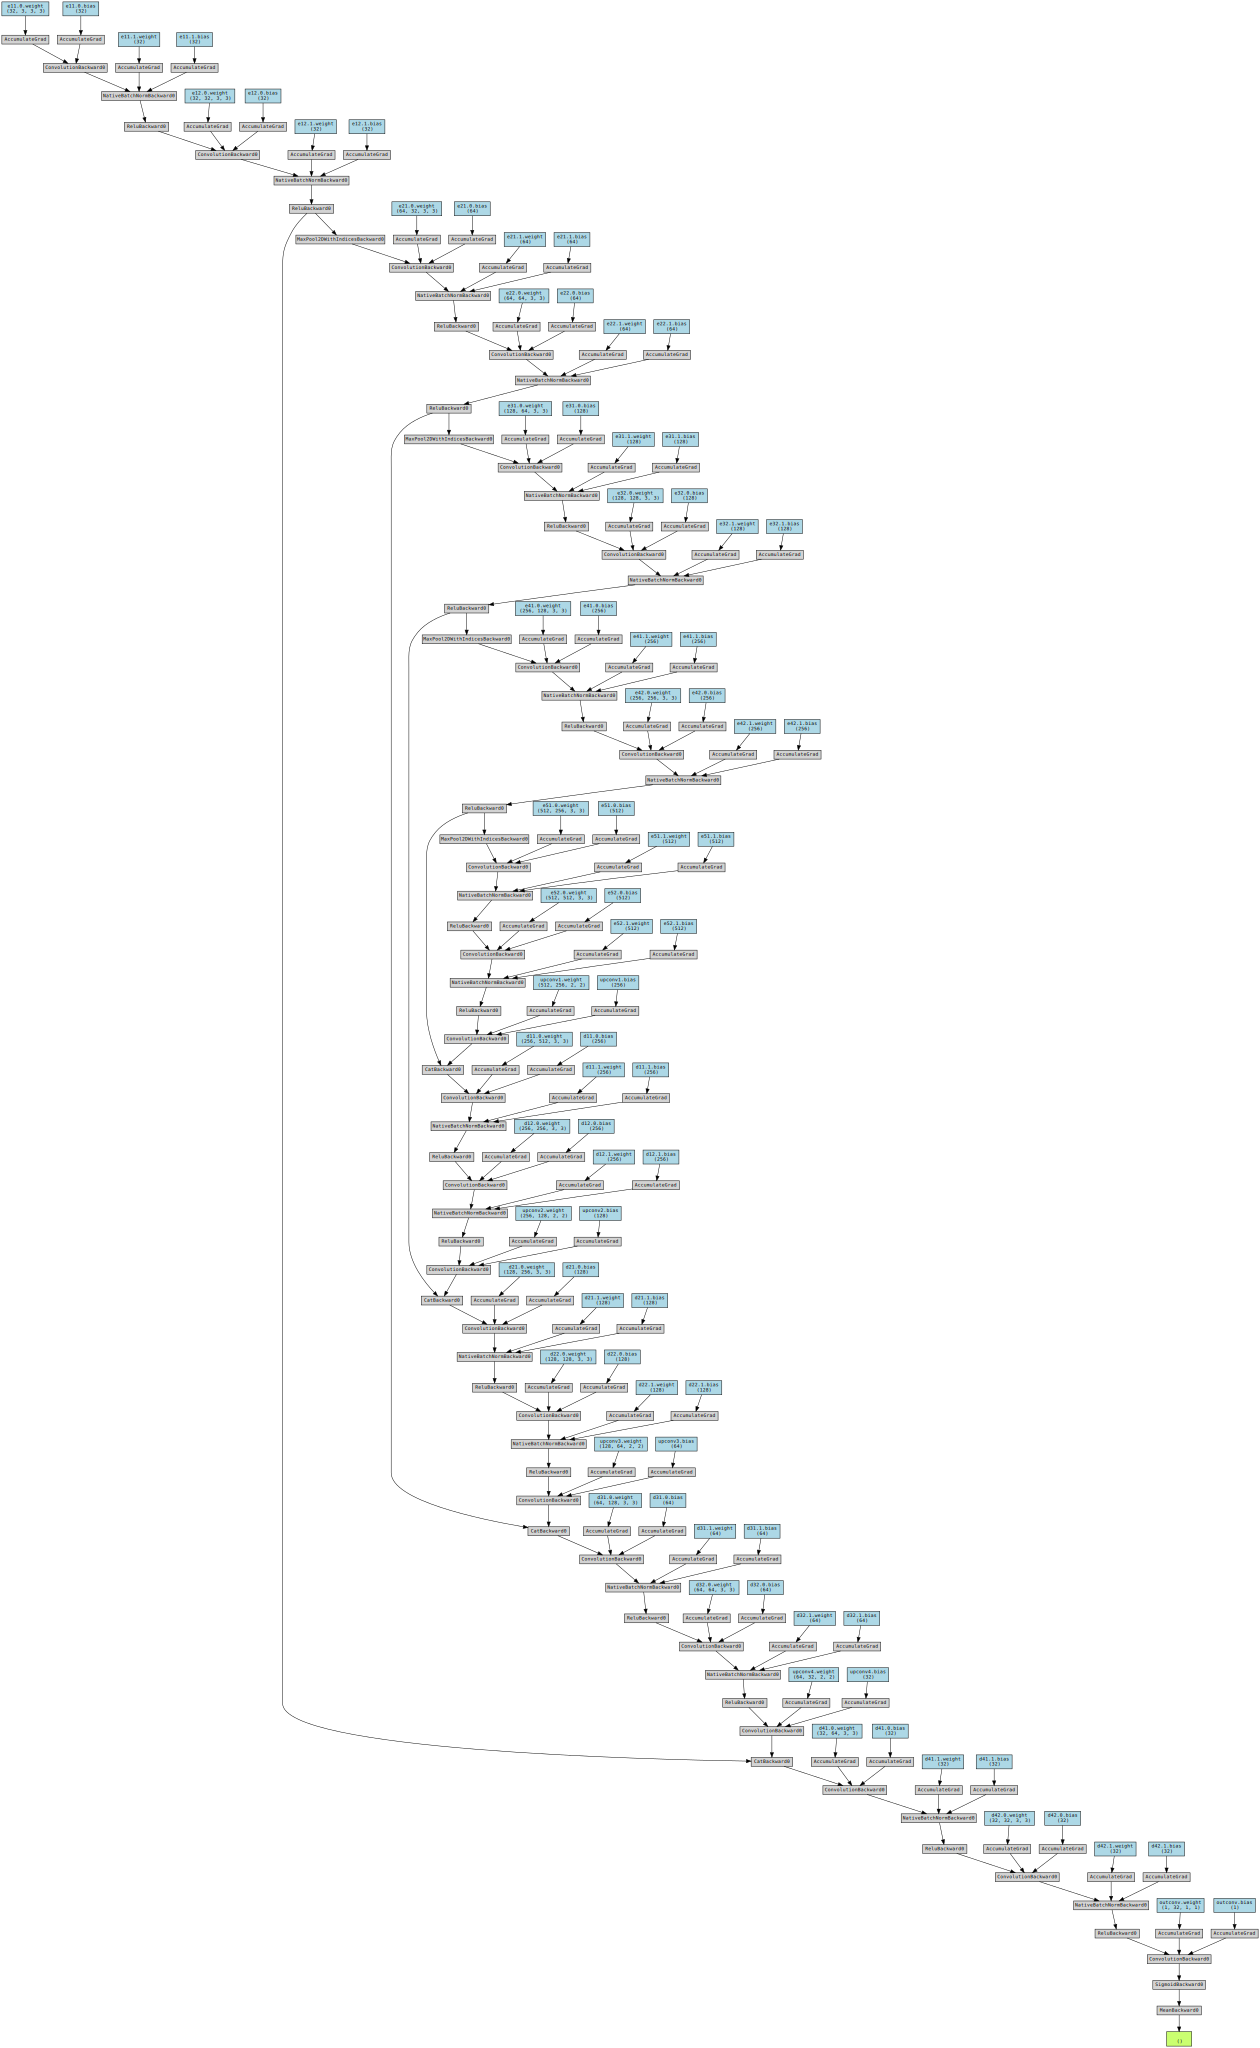

In [30]:
size = (batch_size, 3, 256, 256)
X = torch.randn(size)
modelw = UNet(n_class=1)
y = modelw(X)

make_dot(y.mean(), params=dict(modelw.named_parameters()))

# Loss function
#### Jaccard index
**Robust to Class Imbalance:** The Jaccard Index inherently takes into account the overlap between the predicted segmentation mask and the ground truth mask. This can help mitigate the impact of class imbalance to some extent. Since it focuses on the intersection and union of the positive regions, it rewards accurate localization of object boundaries regardless of their prevalence.

**Encourages Accurate Object Localization:** The Jaccard Index penalizes false positives and false negatives equally, emphasizing accurate localization of objects rather than merely predicting the majority class.

**Directly Optimizes Task Performance:** Using a metric like IoU as a loss function aligns the optimization process directly with the evaluation metric you care about, which can lead to models that perform better according to the task's ultimate goal.

In [31]:
import torchmetrics
from torchmetrics.classification import Dice
from torchmetrics.classification import BinaryJaccardIndex


In [32]:
class JaccardLoss(torch.nn.Module):
    """
    Jaccard Loss (Intersection over Union loss) for semantic segmentation.

    This loss measures the dissimilarity between the predicted and target binary masks
    using the Jaccard Index (IOU) metric. It is used for tasks like semantic segmentation.

    Shape:
        - Predictions: (N, C, H, W), where N is the batch size, C is the number of classes,
          H is the height, and W is the width.
        - Targets: (N, C, H, W), same shape as predictions.

    Returns
    ----------------
    Loss : torch.Tensor
    A scalar tensor representing the Jaccard loss.

    ```
    """

    def __init__(self):
        super(JaccardLoss, self).__init__()

    def forward(self, predictions, targets):
        """
        Compute the Jaccard Loss between predictions and target masks.

        Args:
            predictions (torch.Tensor): Predicted binary masks. Shape (N, C, H, W).
            targets (torch.Tensor): Target binary masks. Shape (N, C, H, W).

        Returns:
            torch.Tensor: The computed Jaccard loss as a scalar tensor.
        """
        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions + targets) - intersection
        iou = intersection / (union + 1e-6)  # Adding a small epsilon to prevent division by zero
        loss = 1 - iou
        return loss


In [33]:
# Primary learning rate
lr = 1e-2

# Initializing loss function
lossFunction = JaccardLoss()

# IOUmetric = Dice(average='micro').to(device).requires_grad_()

# # Initializing the optimizer
# optimizer = torch.optim.SGD(model.parameters(),
#                                 lr=lr,
#                                 # In order to minimize the mode complexity
#                                 momentum = 0.9, # 0,9 is recommended for momentum in literture
#                                 nesterov = True,
#                                 weight_decay =0.01)

optimizer = torch.optim.Adam(model.parameters())

# Changing the lr using lambda scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Traing the model

### Gradient hooking

Certainly! Gradient hooks, often referred to simply as hooks, are a feature in deep learning frameworks like PyTorch that allow you to attach functions to specific operations or layers in a neural network. These functions are executed during the forward and backward passes of training. Gradient hooks are primarily used to inspect, modify, or record gradient information as it flows through the network. Here's a simple explanation:

**Attachment to Layers/Operations**: You can attach a hook to a specific layer or operation within your neural network. This hook will be triggered when that layer or operation is used during both forward and backward passes.

**Forward Pass**: During the forward pass, the hook function can inspect the input and output of the layer or operation it's attached to. This is useful for tasks like visualization or monitoring intermediate activations.

**Backward Pass (Gradients)**: During the backward pass (when gradients are computed), the hook can access and record gradient information as it flows backward through the network. This is especially useful for debugging or understanding how gradients are propagating.

In summary, gradient hooks allow you to peek into the internal workings of a neural network, examining both forward and backward pass information. They are a powerful tool for debugging and gaining insights into the behavior of your neural network during training.


Visualizing the gradient flow helps you understand how gradients propagate through the layers of a neural network during the backward pass. To visualize the gradient flow, you can use gradient hooking.


### Gradient accumulation
Since I have memory problem :), I'll use gradient accumulation

**Point**: Dimension reduction is not used here since patterns and textures are crucial for this data at hand.

**Ponit**: We usually use minibatch gradient decent to properly fit the data into the momery and reaching a higher convergence. But unfortunatelly because i DO not have a large memory size, my mini batches are set to 2. So, the convergence can not function as expected.

Gradient accumulation is a technique used in training neural networks where gradients computed during multiple mini-batches are accumulated before updating the model's parameters. Instead of updating the model's parameters after each mini-batch, gradients are summed or averaged over a certain number of mini-batches before performing a parameter update. This can be useful in various scenarios:


**Memory Constraints**: Some models might have large memory requirements, and accumulating gradients over several mini-batches can help mitigate memory limitations. This allows you to effectively train models that might otherwise not fit in the GPU memory.

**Large Batch Training**: Training with large batch sizes can sometimes lead to unstable convergence or poor generalization. Gradient accumulation can simulate larger effective batch sizes without using excessive memory, leading to smoother training dynamics.

**Stable Optimization**: In some cases, gradient noise can lead to unstable optimization. By accumulating gradients, you can reduce the effect of noise and potentially achieve better convergence.

Here's a simplified explanation of how gradient accumulation works:

1. Compute the gradients for each mini-batch as usual.
2. Instead of updating the model's parameters immediately, accumulate the gradients by adding them up.
3. After processing a certain number of mini-batches, average or scale the accumulated gradients.
4. Perform a single parameter update using the averaged or scaled gradients.

In [34]:
# Customizing tqdm appearance
tqdm_kwargs = {
    'desc': 'Epochs',
    'dynamic_ncols': True,
    'leave' : True,
    'colour': 'purple',  # Set the color to purple
}

**Point**: You need to hook the gradients to store them, otherwise `torch.tensor.grad` would return a None value

In [35]:
# saving the gradients to visualize
# gradient_norms_dict = register_gradient_hooks(model)


epochNum = 100
patienceLim = 8
patience = 0
accumulationStep = torch.tensor([5]).to(device)
totalLoss = torch.tensor(0.0).to(device).requires_grad_()

bestIOU = 0
# Since we use IOU (jaccard index) for both loss
# and validation metric, so onspecting one of them
# would be enough because the are the same
trainLosses, ValLosses = [], []


# Looping over the data generators
for epoch in range(epochNum):

    # Hello gradient!
    model.train()
    runingLoss = 0.0

    for counter, (img, mask) in enumerate(TrainLoader):

        # Sening the inputs and outputs to cuda
        img = img.to(device).requires_grad_()
        mask = mask.to(device).unsqueeze(1)

        # prediction
        out = model(img)

        # Calculating the loss to propagate through
        # the network
        lossTrain = lossFunction(out, mask)


        lossTrain.backward()

        # parameters updated
        optimizer.step()

        runingLoss += lossTrain.item()


        optimizer.zero_grad()


    # Statistic (After each epoch)

    # Train statitics
    trainLosses.append(runingLoss/(counter + 1))

    # Validation statistics
    with torch.no_grad():
        valRuningLoss = 0.0

        for valCounter, (valImg, valMask) in enumerate(ValLoader):

            valImg = valImg.to(device)
            valMask = valMask.to(device).unsqueeze(1)


            valOut = model(valImg)

            valLoss = lossFunction(valOut, valMask)
            valRuningLoss += valLoss.item()

        vlLoss = valRuningLoss/(valCounter+1)
        ValLosses.append(vlLoss)


    # Early stopping
    bestIOU, patience = CallBacks.earlyStopping(bestIOU,
                                                1-vlLoss,
                                                patience,
                                                model)
    if patience > patienceLim: break

    print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>")
    print("Epoch number: ", epoch)
    print("Best IOU: ", bestIOU)
    print("The IOU of the current epoch: ", 1-vlLoss)






<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch number:  0
Best IOU:  0.13502013157395754
The IOU of the current epoch:  0.13502013157395754
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch number:  1
Best IOU:  0.27053083742366113
The IOU of the current epoch:  0.27053083742366113
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch number:  2
Best IOU:  0.33778827856568727
The IOU of the current epoch:  0.33778827856568727
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch number:  3
Best IOU:  0.33778827856568727
The IOU of the current epoch:  0.33338778509813194
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch number:  4
Best IOU:  0.39266395393539877
The IOU of the current epoch:  0.39266395393539877
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch number:  5
Best IOU:  0.39266395393539877
The IOU of the current epoch:  0.387948693598018
<><><><><><><><><><><><><><><><><><><><><>

## variation of train and validation loss

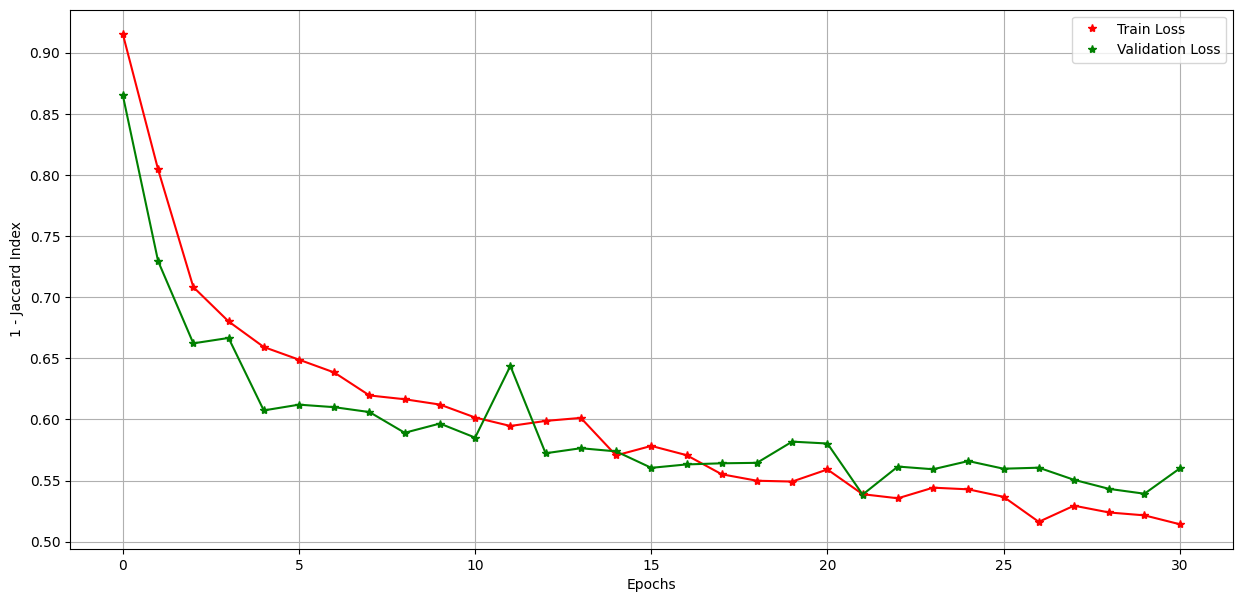

In [37]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(trainLosses, "r*")
ax.plot(ValLosses, "g*")

ax.legend(["Train Loss", "Validation Loss"])
ax.plot(trainLosses, "r")
ax.plot(ValLosses, "g")
ax.set_xlabel("Epochs")
ax.set_ylabel("1 - Jaccard Index")
ax.grid()
plt.show()

### Inspecting the model output

#### Recreating the best saved model

In [ ]:
# Initialize
finalModel = UNet(n_class=1)

# Load weight
loadPath = "/content/drive/MyDrive/ZamanPersonalUsage/vesselSegmentation/models/BestModel.pth"
finalModel.load_state_dict(torch.load(loadPath))

# Visualization

In [22]:
fig, ax = plt.subplots(batch_size-1, 4, figsize=(20, 35))

finalModel.eval()

for img_batch, mask_batch in ValLoader:
    for counter in range(len(img_batch)-1):
        img, mask = img_batch[counter], mask_batch[counter]

        # Sending to cuda and adding the batch size dimension!
        img = img.to(device).unsqueeze(0)

        # prediction
        out = model(img)


        # Getting everything ready for plotting the imagesv
        img = img.squeeze(0).permute(2, 1, 0).detach().cpu().numpy()
        out = out.squeeze(0).permute(2, 1, 0).detach().cpu().numpy().astype(np.uint8)
        mask = mask.unsqueeze(0).permute(2, 1, 0).numpy().astype(np.uint8)


        # Since we standardized the pictures
        img = img * std + mean

        # Overlay mask image to the original image
        overlayed_img = cv2.bitwise_and(img, img, mask=out)

        ax[counter, 0].imshow(img)
        ax[counter, 0].set_title("Original Image")
        ax[counter, 0].axis("off")

        ax[counter, 1].imshow(mask)
        ax[counter, 1].set_title("Mask")
        ax[counter, 1].axis("off")

        ax[counter, 2].imshow(out)
        ax[counter, 2].set_title("Model output")
        ax[counter, 2].axis("off")

        ax[counter, 3].imshow(overlayed_img)
        ax[counter, 3].set_title("Overlayed Image")
        ax[counter, 3].axis("off")

    plt.show()
    break

    # break

## mlflow

We now try to predict the validation data using the best saved model and average them.

In [23]:
with torch.no_grad():
    validationIOU = torch.tensor([0.0])

    for valCounter, (valImg, valMask) in tqdm.tqdm(enumerate(ValLoader)):

        valImg = valImg.to(device)
        valMask = valMask.to(device).unsqueeze(1)


        valOut = model(valImg)

        valLoss = lossFunction(valOut, valMask)
        validationIOU += 1 - valLoss.item()

validationIOU = validationIOU/valCounter

34it [00:07,  4.68it/s]


In [24]:
print("Mean of (1- Jaccard Index): ", validationIOU.mean().item())

Mean of (1- Jaccard Index):  0.37548574805259705


In [25]:
hyperparameter = {
        "batch_size" : batch_size,
        "learning_rate" : lr,
        "dimension" : 256,
        "pytorch_total_params": pytorch_total_params,
        "lossFunction": type(lossFunction).__name__,
        "optimize" : type(optimizer).__name__,
        "Initialization": "Default",
        "Augmentation": "None",
        "pytorch_version": torch.__version__
}

metrics = {
    "Validation IOU": validationIOU.mean().item()
}

In [26]:
# Where to save the mlflown runs
mlflowSaveDir = "/content/drive/MyDrive/ZamanPersonalUsage/vesselSegmentation/models/mlflow"
mlflow.set_tracking_uri(mlflowSaveDir)

mlflow.set_experiment("Vessel segementaion")
# Start an MLflow run
with mlflow.start_run():

    # Log the dictionary of parameters
    mlflow.log_params(hyperparameter)

    # Log Metrics
    mlflow.log_metrics(metrics)

    # loging the model
    mlflow.pytorch.log_model(finalModel, "model")

    mlflow.log_figure(fig, "Train and Validation loss graph.png")


# End the MLflow run
mlflow.end_run()


2023/09/30 20:57:43 INFO mlflow.tracking.fluent: Experiment with name 'Vessel segementaion' does not exist. Creating a new experiment.
2023/09/30 20:57:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/09/30 20:57:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


## View mlflow

In [ ]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [ ]:
!mlflow ui